In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from CoolProp.CoolProp import PropsSI

In [2]:
air = PropsSI('D','T',300,'P',101325,'Air')  # Density of air at 300K and 1 atm

In [3]:
def rho_air(T, P):
    return PropsSI('D', 'T', T, 'P', P, 'Air')
def cp_air(T, P):
    return PropsSI('C', 'T', T, 'P', P, 'Air')
def mu_air(T, P):
    return PropsSI('V', 'T', T, 'P', P, 'Air')
def k_air(T, P):
    return PropsSI('L', 'T', T, 'P', P, 'Air')  
def Pr_air(T, P):
    return cp_air(T, P) * mu_air(T, P) / k_air(T, P)
def nu_air(T, P):
    return mu_air(T, P) / rho_air(T, P)
def alpha_air(T, P):
    return k_air(T, P) / (rho_air(T, P) * cp_air(T, P))
def Re_air(V, L, T, P):
    return rho_air(T, P) * V * L / mu_air(T, P)
def Nu_air(Re, Pr):
    if Re < 2300:
        return 3.66  # Laminar flow in a pipe
    else:
        return 0.023 * Re**0.8 * Pr**0.3  # Turbulent flow in a pipe

def Nu_lecho(Re, Pr):
        return 2 + 1.1 * (Re**0.6) * (Pr**0.33) 
def epsilon(D,dp):
    return 0.4272 - 4.516e-3 * (dp / D) + 7.881e-5 * (dp / D)**2
def Re_lecho(D, dp,vf , T, P):
    return dp * epsilon(D, dp) * vf * rho_air(T,P) / mu_air(T,P)
def h_lecho(D, dp, vf, T, P):
    Re = Re_lecho(D, dp, vf, T, P)
    Pr = Pr_air(T, P)
    Nu = Nu_lecho(Re, Pr)
    k = k_air(T, P)
    return Nu * k / dp



In [4]:
# parametros
L = 4.218  # m
D = 2  # m
Area =  np.pi * D**2/4  # m2
m_g = 1  # kg/s
T_g_in = 923.15 # K
P_sistem = 101325  # Pa
rho_g = rho_air(T_g_in, P_sistem)  # kg/m3
vf = m_g / (rho_g * Area)  # m/s

Dp = 0.025  # m

eps = epsilon(D, Dp)  # fraccion de vacios

a = 6*(1 - eps) / Dp  # m2/m3
h_air = h_lecho(D, Dp, vf, T_g_in, P_sistem)  # W/m2K
Cp_g = cp_air(T_g_in, P_sistem)  # J/kgK

rho_p = 2768  # kg/m3
Cp_p = 852.1  # J/kgK

T_p0 = 25+273.15  # K
print(f"Propiedades del aire a T={T_g_in} K y P={P_sistem} Pa:")
print(f"viscosidad aire: {mu_air(T_g_in,P_sistem):.6f} Pa.s")
print(f"Re lecho: {Re_lecho(D, Dp,vf , T_g_in, P_sistem):.2f}")
print(f"Prandtl aire: {Pr_air(T_g_in,P_sistem):.4f}")
print(f"conductividad aire: {k_air(T_g_in,P_sistem):.4f} W/mK")
print(f"capacidad calorifica aire: {Cp_g:.2f} J/kgK")
print(f"Area: {Area:.2f} m2")
print(f"velocidad del aire: {vf:.2f} m/s")
print(f"Densidad aire: {rho_g:.2f} kg/m3")
print(f"m_g: {m_g:.2f} kg/s")
print(f"a: {a:.2f} m2/m3")
print(f"epsilon: {eps:.4f}")
print(f"h_air: {h_air:.2f} W/m2K")

dP = L*((150*mu_air(T_g_in,P_sistem)*vf*(1-eps)**2)/(Dp**2*eps**3) + ((1.75*rho_g*(1-eps)*vf**2)/(Dp*eps**3)))  # Pa
print(f"Pérdida de presión: {dP:.2f} Pa")

Propiedades del aire a T=923.15 K y P=101325 Pa:
viscosidad aire: 0.000041 Pa.s
Re lecho: 82.76
Prandtl aire: 0.7254
conductividad aire: 0.0637 W/mK
capacidad calorifica aire: 1125.76 J/kgK
Area: 3.14 m2
velocidad del aire: 0.83 m/s
Densidad aire: 0.38 kg/m3
m_g: 1.00 kg/s
a: 137.49 m2/m3
epsilon: 0.4271
h_air: 40.79 W/m2K
Pérdida de presión: 721.09 Pa


### Caso 0D


In [5]:
def modelo_carga(t, y):
    Tg, Tp = y  # extraer las variables de estado
    # Ecuaciones diferenciales acopladas
    dTg_dt = (m_g / (rho_g * Area * eps * L)) * (T_g_in - Tg) \
             - (h_air * a / (rho_g * eps * Cp_g)) * (Tg - Tp)
    dTp_dt = (h_air * a / (rho_p * (1 - eps) * Cp_p)) * (Tg - Tp)
    return [dTg_dt, dTp_dt]

In [6]:
y0 = [T_p0,T_p0]  # Tg(0)=Tp(0)=293 K
dt = 0.5
tiempo = 4*3600 # Total time in seconds
t_span = (0, tiempo)
t_eval = np.arange(0, tiempo, dt)
sol_carga_0D = solve_ivp(modelo_carga, t_span, y0, method='RK45', t_eval=t_eval)

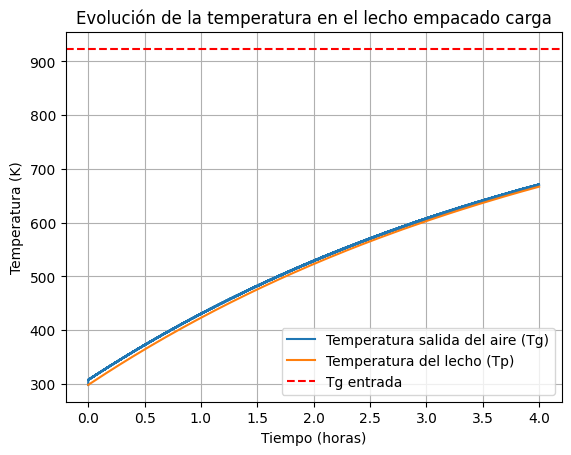

670.3189715754866


In [7]:
plt.plot(sol_carga_0D.t/3600, sol_carga_0D.y[0], label='Temperatura salida del aire (Tg)')
plt.plot(sol_carga_0D.t/3600, sol_carga_0D.y[1], label='Temperatura del lecho (Tp)')
# se agrega una linea horizontal para la temperatura de entrada del aire
plt.axhline(y=T_g_in, color='r', linestyle='--', label='Tg entrada')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Temperatura (K)')
plt.legend()
plt.grid()
plt.title('Evolución de la temperatura en el lecho empacado carga')
plt.show()
print(sol_carga_0D.y[0][-1])  # Temperatura final del aire a la salida del lecho

In [8]:
# Definición del modelo de descarga
T_g_des = 298.15
def modelo_descarga(t, y):
    Tg, Tp = y  # extraer las variables de estado
    # Ecuaciones diferenciales acopladas
    dTg_dt = (m_g / (rho_g * Area * eps * L)) * (T_g_des - Tg) \
             + (h_air * a / (rho_g * eps * Cp_g)) * -(Tg - Tp)
    dTp_dt = -(h_air * a / (rho_p * (1 - eps) * Cp_p)) * -(Tg - Tp)
    return [dTg_dt, dTp_dt]

In [9]:
y0 = [sol_carga_0D.y[1][-1], sol_carga_0D.y[1][-1]]  # Tg(0)=Tp(0)=293 K
dt = 1
tiempo = 4*3600 # Total time in seconds
t_span = (0, tiempo)
t_eval = np.arange(0, tiempo, dt)
sol_descarga_0D = solve_ivp(modelo_descarga, t_span, y0, method='RK45', t_eval=t_eval)

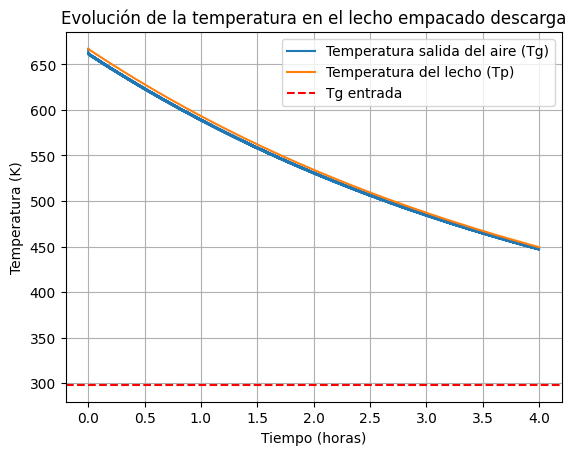

447.3347158756554


In [10]:
plt.plot(sol_descarga_0D.t/3600, sol_descarga_0D.y[0], label='Temperatura salida del aire (Tg)')
plt.plot(sol_descarga_0D.t/3600, sol_descarga_0D.y[1], label='Temperatura del lecho (Tp)')
# se agrega una linea horizontal para la temperatura de entrada del aire
plt.axhline(y=T_g_des, color='r', linestyle='--', label='Tg entrada')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Temperatura (K)')
plt.legend()
plt.grid()
plt.title('Evolución de la temperatura en el lecho empacado descarga')
plt.show()
print(sol_descarga_0D.y[0][-1])  # Temperatura final del aire a la salida del lecho

In [11]:
# energia almacenada y usada por el calentador
Q_almacenada = rho_p * (1 - eps) * Cp_p * Area * L * (sol_carga_0D.y[1][-1] - T_p0) # J
Q_heater = 671.818 * 3600 * 4  # kwh consumo calentador

Razon_energia = Q_almacenada / (Q_heater * 1000)  # fracción de energía almacenada respecto a la consumida por el calentador
print(f"Energía almacenada: {Q_almacenada/1e6:.2f} MJ")
print(f"Energía consumida por el calentador: {Q_heater/1e3:.2f} MJ")
print(f"Razón de energía almacenada a consumida: {Razon_energia:.4f}")

Energía almacenada: 6602.97 MJ
Energía consumida por el calentador: 9674.18 MJ
Razón de energía almacenada a consumida: 0.6825


### 1D


In [12]:
# nodos direccion Z
n = 100
# time step
dt = 1 # s

# grilla de z
z = np.linspace(0, L, n + 1 ) # m
print(len(z))
# espaciamiento
dz = L/(n) # m
print(dz)
# condiciones iniciales
T_g0 = np.ones(n+1) # °C

# tiempo inicial
t0 = 0  # s
# tiempo final
tf = 3600*4  # s
# tiempo de evaluacion
t_eval = np.arange(t0, tf, dt)
# intervalo de tiempo
t_span = (t0, tf)

101
0.04218


Carga, mediante aire caliente
aire:
$$
\frac{dT_g}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon}\frac{dT_g}{dz} -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_g-T_p)
$$
Lecho:
$$
\frac{dT_p}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_g-T_p)
$$

Aplicando diferencias finitas:

central:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i+1}}-T_{g_{i-1}}}{2\Delta z}
$$

inicio
condicion de borde inicial:
$$
T_{g_{1}}(0,t) = T_{g_{in}}
$$
$$
\frac{\partial T_{g_{1}}(L,t)}{\partial z} = 0
$$
condiciones iniciales
$$
T_{g_{1}}(z,0) = T_{p_{in}}
$$

$$
T_{p_{1}}(z,0) = T_{p_{in}}
$$


backward:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z}
$$
$$
\frac{dT_{g_i}}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon}\frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z} -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_{g_i}-T_p)
$$

$$
\frac{dT_{g_i}}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}T_{g_{i-1}}-\left(\frac{ha}{\rho_g C_{p_{g}}\epsilon}+\frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}\right) T_{g_i} +  \frac{ha}{\rho_g C_{p_{g}}\epsilon} T_p
$$

Lecho:
$$
\frac{dT_{p_i}}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_{g_i}-T_{p_i})
$$

$$
\frac{dT_{p_i}}{dt} = - \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{p_i} + \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{g_i} 
$$

In [13]:
# parametros
L = 4.218  # m
D = 2  # m
Area =  np.pi * D**2/4  # m2
m_g = 1  # kg/s
T_g_in = 923.15 # K
P_sistem = 101325  # Pa
rho_g = rho_air(T_g_in, P_sistem)  # kg/m3
vf = m_g / (rho_g * Area)  # m/s

Dp = 0.025  # m

eps = epsilon(D, Dp)  # fraccion de vacios

a = 6*(1 - eps) / Dp  # m2/m3
h_air = h_lecho(D, Dp, vf, T_g_in, P_sistem)  # W/m2K
Cp_g = cp_air(T_g_in, P_sistem)  # J/kgK

rho_p = 2768  # kg/m3
Cp_p = 852.1  # J/kgK

T_p0 = 25+273.15  # K

In [14]:
def TES_carga(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, Area):
    # Ecuación diferencial
    n = int(len(y)- 2)
    T_p = y[0].copy()
    T_g = y[1:].copy()
    dT_gdt = np.zeros(n+1)
    for i in range(1,n+1):
        dT_gdt[i] =  m_g/(rho_g * Area * epsilon * dz) * T_g[i-1] - ( (h_air * a)/(rho_g * Cp_g * epsilon) + (m_g/(rho_g * Area * epsilon * dz)) ) * T_g[i] + (h_air * a)/(rho_g * Cp_g * epsilon) * T_p
    dT_pdt = - (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_p + (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * np.mean(T_g)
    dy = np.empty_like(y)
    dy[0] = dT_pdt
    dy[1:] = dT_gdt
    return dy

T_g0 = np.ones(n+1) * T_p0

T_g0[0] = T_g_in

y0 = np.concatenate([np.array([T_p0]), T_g0])

sol_carga_1D = solve_ivp(TES_carga, t_span, y0, method="BDF", t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area))

/tmp/ipykernel_2174/3982297135.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


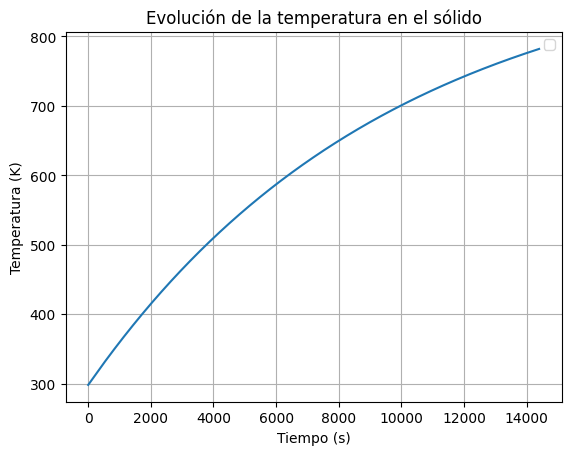

/tmp/ipykernel_2174/3982297135.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


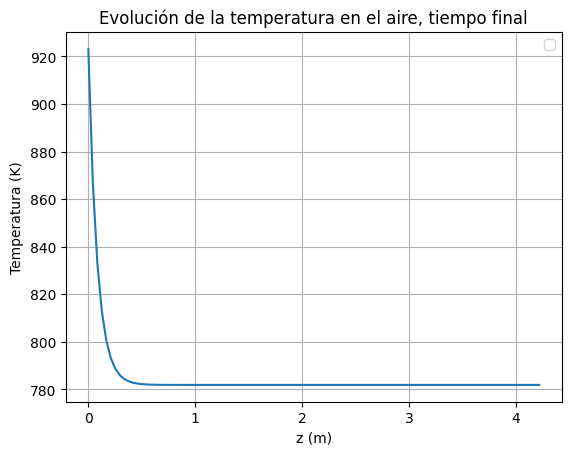

/tmp/ipykernel_2174/3982297135.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


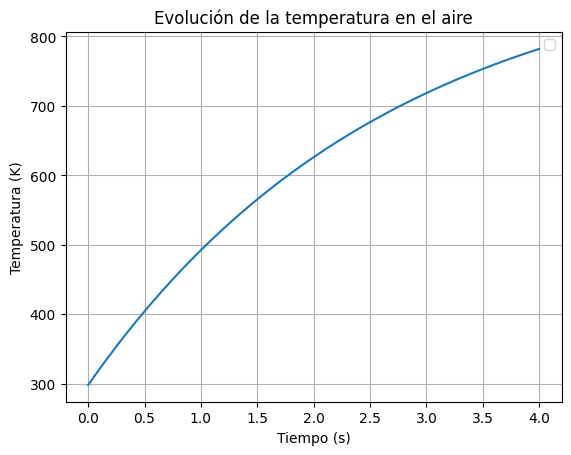

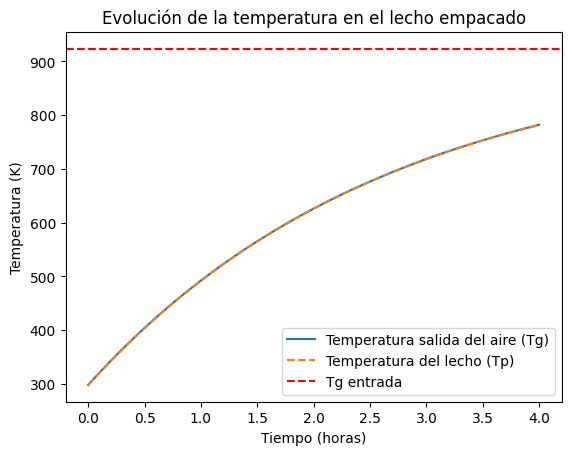

In [15]:
T_p_sol = sol_carga_1D.y[0,:]
T_g_sol = sol_carga_1D.y[1:,:]
tiempo_carga = sol_carga_1D.t

# figura lecho respecto al tiempo
Tp_t = T_p_sol[:].copy()
plt.figure()
plt.plot(tiempo_carga,Tp_t)
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el sólido')
plt.legend()
plt.grid()
plt.show()
# figura aire respecto a z
plt.figure()
Tg_t = T_g_sol[:,-10]  
plt.plot(z,Tg_t)
plt.xlabel('z (m)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el aire, tiempo final')
plt.legend()
plt.grid()
plt.show()  

plt.figure()
Tg_t = T_g_sol[-1, 1:]  
plt.plot(tiempo_carga[1:]/3600,Tg_t)
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el aire')
plt.legend()
plt.grid()
plt.show()  

plt.figure()
Tg_t = T_g_sol[-1, :]
Tp_t = T_p_sol[:].copy()
plt.plot(tiempo_carga/3600, Tg_t ,label='Temperatura salida del aire (Tg)')
plt.plot(tiempo_carga/3600, Tp_t ,linestyle='--',label='Temperatura del lecho (Tp)')
# se agrega una linea horizontal para la temperatura de entrada del aire
plt.axhline(y=T_g_in, color='r', linestyle='--', label='Tg entrada')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Temperatura (K)')
plt.legend()
plt.title('Evolución de la temperatura en el lecho empacado')
plt.show()


### Descarga 1D


Carga, mediante aire caliente
aire:
$$
\frac{dT_g}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon}\frac{dT_g}{dz} +\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_p-T_g)
$$
Lecho:
$$
\frac{dT_p}{dt} = -\frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_p-T_g)
$$

Aplicando diferencias finitas:

central:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i+1}}-T_{g_{i-1}}}{2\Delta z}
$$

inicio
condicion de borde inicial:
$$
T_{g_{1}}(0,t) = T_{g_{in}}
$$
$$
\frac{\partial T_{g_{1}}(L,t)}{\partial z} = 0
$$
condiciones iniciales
$$
T_{g_{1}}(z,0) = T_{g_{in}}
$$

$$
T_{p_{1}}(z,0) = T_{p_{carga}}
$$


backward:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z}
$$
$$
\frac{dT_{g_i}}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon}\frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z} +\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_p-T_{g_i})
$$

$$
\frac{dT_{g_i}}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}T_{g_{i-1}}+\left(-\frac{ha}{\rho_g C_{p_{g}}\epsilon}+\frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}\right) T_{g_i} +  \frac{ha}{\rho_g C_{p_{g}}\epsilon} T_p
$$

Lecho:
$$
\frac{dT_{p_i}}{dt} = -\frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_{p_i}-T_{g_i})
$$

$$
\frac{dT_{p_i}}{dt} = - \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{p_i} + \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{g_i} 
$$

In [18]:
def TES_descarga(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, Area):
    # Ecuación diferencial
    n = int(len(y)- 2)
    T_p = y[0].copy()
    T_g = y[1:].copy()
    dT_gdt = np.zeros(n+1)
    for i in range(1,n+1):
        dT_gdt[i] =  - m_g/(rho_g * Area * epsilon * dz) * T_g[i-1] + ( -(h_air * a)/(rho_g * Cp_g * epsilon) + (m_g/(rho_g * Area * epsilon * dz)) ) * T_g[i] + (h_air * a)/(rho_g * Cp_g * epsilon) * T_p
    dT_pdt = - (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_p + (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * np.mean(T_g)
    dy = np.empty_like(y)
    dy[0] = dT_pdt
    dy[1:] = dT_gdt
    return dy

T_g_des = 298.15
T_p0 = sol_carga_1D.y[0,-1]
T_g0 = np.ones(n+1) * T_g_des

T_g0[0] = T_g_des

y0 = np.concatenate([np.array([T_p0]), T_g0])

sol_descarga_1D = solve_ivp(TES_descarga, t_span, y0, method="BDF", t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area))

KeyboardInterrupt: 

In [ ]:
T_p_des = sol_descarga_1D.y[0,:]
T_g_des = sol_descarga_1D.y[1:,:]
tiempo_descarga = sol_descarga_1D.t

# figura lecho respecto al tiempo
Tp_t_des = T_p_des[:].copy()
plt.figure()
plt.plot(tiempo_descarga,Tp_t_des)
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el sólido')
plt.legend()
plt.grid()
plt.show()
# figura aire respecto a z
plt.figure()
Tg_t_des = T_g_des[:,-10]  
plt.plot(z,Tg_t_des)
plt.xlabel('z (m)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el aire, tiempo final')
plt.legend()
plt.grid()
plt.show()  

plt.figure()
Tg_t_des = T_g_des[-1, 1:]  
plt.plot(tiempo_descarga[1:]/3600,Tg_t_des)
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el aire')
plt.legend()
plt.grid()
plt.show()  

plt.figure()
Tg_t_des = T_g_des[-1, :]
Tp_t_des = T_p_des[:].copy()
plt.plot(tiempo_descarga/3600, Tg_t_des ,label='Temperatura salida del aire (Tg)')
plt.plot(tiempo_descarga/3600, Tp_t_des ,linestyle='--',label='Temperatura del lecho (Tp)')
# se agrega una linea horizontal para la temperatura de entrada del aire
plt.axhline(y=T_g_in, color='r', linestyle='--', label='Tg entrada')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Temperatura (K)')
plt.legend()
plt.title('Evolución de la temperatura en el lecho empacado')
plt.show()

#### HASTA AQUI


def TES_carga(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, A):
    # Ecuación diferencial
    T_p = y[0]
    T_g = y[1]
    dT_gdt = -m_g/(rho_g*A*epsilon) - (h_air*a/(rho_g*Cp_g*epsilon))*(T_g - T_p)
    dT_pdt = (h_air*a/(rho_p*Cp_p*(1-epsilon)))*(T_g - T_p)
    return [dT_pdt]